<a href="https://colab.research.google.com/github/emilyj19/TS/blob/master/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = 'gdrive/My Drive/FinancialTS/JPmarket_dataset.npz' 
data = np.load(root_path)

In [0]:
data.files

['train_ratios', 'test_ratios', 'train_volumes', 'test_volumes']

In [0]:
train_ratios = data['train_ratios']
test_ratios = data['test_ratios']
train_vols = data['train_volumes']
test_vols = data['test_volumes']

In [0]:
train_ratios.shape

(499, 462, 64)

In [0]:
#plot curves 
vol_list = []
for i in range(mini_train_vols[9].shape[0]): 
  vol_list = vol_list + mini_train_vols[0,i,-1:].tolist()
  #vol_list.append(mini_train_vols[0,i,:].tolist())




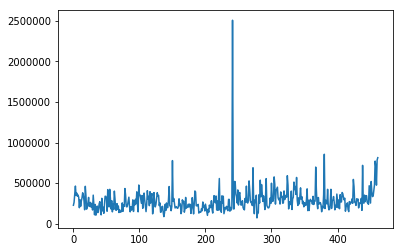

In [0]:
plt.plot(vol_list)

In [0]:
mini_train_ratios = train_ratios[:10]
mini_test_ratios = test_ratios[:10]
mini_train_vols = train_vols[:10]
mini_test_vols = test_vols[:10]

In [0]:
#loss function here 
def ModelLoss(actual, pred, N):
  square_loss_matrix = np.square(actual[:,N:] - pred)
  loss = np.mean(np.mean(np.mean(square_loss_matrix, axis = 2), axis = 1))
  return loss

In [0]:
#baseline here 

#moving average 
ratio_pred_MA = np.zeros((499,462-180,64))
for s in range(499):
  #N = 180 days for each prediction so 462 - 180 = 282 preds
  for d in range(180, train_ratios.shape[1]): 
    for t in range(train_ratios.shape[2]): 
      pred_t = np.mean(train_ratios[s,d-180:d,t])
      ratio_pred_MA[s,d-180,t] = pred_t

#generalise this into a function?
      
      
#exponential moving average
#use N = 30 here
ratio_pred_EMA = np.zeros((499,462-30,64))
k = 2/(30+1)
for s in range(499): 
  for d in range(30, train_ratios.shape[1]): 
    for t in range(train_ratios.shape[2]): 
      if (d - 30) == 0: 
        pred_t = np.mean(train_ratios[s,d-30:d,t])
        ratio_pred_EMA[s,d-30,t] = pred_t
      else: 
        pred_t = (1-k)*ratio_pred_EMA[s,d-1-30,t] + k*train_ratios[s,d,t]
        ratio_pred_EMA[s,d-30,t] = pred_t
        

In [0]:
def MovingAverage(data, N):
  no_stocks, days, bins = data.shape
  pred_MA = np.zeros((no_stocks,days-N,bins))
  for s in range(no_stocks):
    for d in range(N, days): 
      for t in range(bins): 
        pred_t = np.mean(train_ratios[s,d-N:d,t])
        pred_MA[s,d-N,t] = pred_t
        
  loss = ModelLoss(data, pred_MA, N)
  
  return pred_MA, loss 

def ExpMovingAverage(data, N): 
  no_stocks, days, bins = data.shape
  pred_EMA = np.zeros((no_stocks,days-N,bins))
  k = 2/(N+1)
  for s in range(no_stocks):
    for d in range(N, days): 
      for t in range(bins): 
        if (d - N) == 0: 
          pred_t = np.mean(data[s,d-N:d,t])
          pred_EMA[s,d-N,t] = pred_t
        else: 
          pred_t = (1-k)*pred_EMA[s,d-1-N,t] + k*data[s,d,t]
          pred_EMA[s,d-N,t] = pred_t
  
  loss = ModelLoss(data, pred_EMA, N)
  
  return pred_EMA, loss 
          

In [0]:
ExpMovingAverage(train_ratios, 30)[1]

0.00017348341437292046

In [0]:
#now do an LSTM 

#train LSTM on each individual time series or on all time series together? doesn't make sense to do on all - should do on each individual one 
#have to choose N time steps to predict using, and split the data into sequences 
#also need to keep constraints.... 
#and do I split the series like we did above, using the same bin each day to predict that bin for hte next day and ignring the rest?


#split the data for input into the LSTM: 

def split_data(N, data): 
  


In [0]:
pip install gluonts

     |████████████████████████████████| 225kB 2.8MB/s 
     |████████████████████████████████| 28.4MB 45.6MB/s 
     |████████████████████████████████| 4.8MB 41.4MB/s 
     |████████████████████████████████| 13.8MB 33.3MB/s 
     |████████████████████████████████| 194kB 40.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
Successfully built ujson
ERROR: spacy 2.1.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: imgaug 0.2.9 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: fastai 1.0.52 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: blis 0.2.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but

In [0]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer


In [0]:
estimator = DeepAREstimator(freq)